## Data preprocessing

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator

DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Augmentation for train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


Save labels into file

In [3]:
import pickle

labels = train_generator.class_indices
print("Label to index:", labels)
idx_to_label = {}

for k, v in labels.items():
    idx_to_label[v] = k
    
print("Index to labels:", idx_to_label)
with open('model/labels.pickle', 'wb') as f:
    pickle.dump(idx_to_label, f, protocol=pickle.HIGHEST_PROTOCOL)

Label to index: {'driver_license': 0, 'id_card': 1}
Index to labels: {0: 'driver_license', 1: 'id_card'}


In [4]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (16, 224, 224, 3)
labels batch shape: (16,)


## Model

Basic CNN

In [5]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
__________

Visualize model

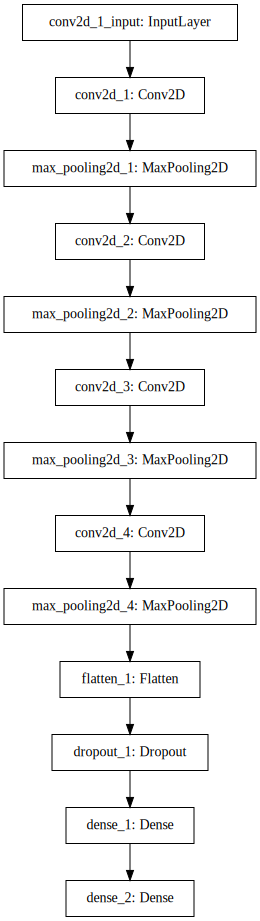

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Checkpoint for only get best `val_acc` model

In [9]:
from keras.callbacks import ModelCheckpoint

if not os.path.exists('model'):
    os.mkdir('model')
    
best_val_acc = ModelCheckpoint('model/cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[best_val_acc]
)

Epoch 1/5
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to model/cnn.h5
1/1 [==============================] - 11s 11s/step - loss: 0.6868 - acc: 0.7500 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 2/5
Epoch 00002: val_acc improved from 0.50000 to 0.75000, saving model to model/cnn.h5
1/1 [==============================] - 7s 7s/step - loss: 0.6804 - acc: 0.6250 - val_loss: 0.6731 - val_acc: 0.7500
Epoch 3/5
Epoch 00003: val_acc did not improve
1/1 [==============================] - 7s 7s/step - loss: 0.6463 - acc: 0.7500 - val_loss: 0.6694 - val_acc: 0.5000
Epoch 4/5
Epoch 00004: val_acc did not improve
1/1 [==============================] - 7s 7s/step - loss: 0.6254 - acc: 0.6250 - val_loss: 0.6791 - val_acc: 0.5000
Epoch 5/5
Epoch 00005: val_acc did not improve
1/1 [==============================] - 7s 7s/step - loss: 0.6768 - acc: 0.5000 - val_loss: 0.8710 - val_acc: 0.5000


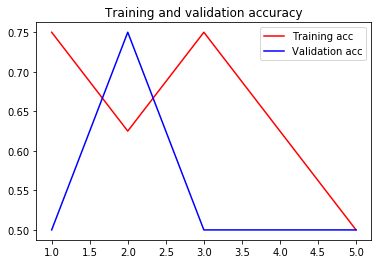

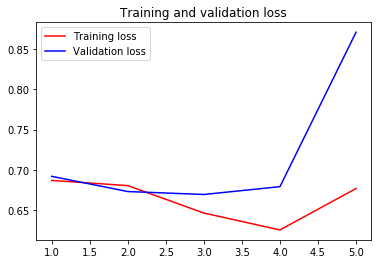

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()